In [1]:
%%html
<style>
div.input {
    display:none;
}
</style>
... *(clear this cell to run it again)* ...

# Analysis of S-layers crystallization kinetics monitored with tr-SAXS

Jonathan Hermann, Frédéric Poitevin, ...

## Introduction

We consider here time-series collected after addition of Calcium on RsaA monomers, thus following the subsequent crystallization process. 

We aim at extracting the underlying components of the SAXS profiles, and their evolution with time.




### Data

We start by considering the dataset with higher concentration (33.7mg/ml). We edited out the first time-points.

In [63]:
# Useful libraries
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from numpy import genfromtxt
from sklearn.decomposition import FastICA, PCA
from msmbuilder.decomposition import tICA

In [64]:
# Data loading
filename='../data/6_q.csv'
raw_q = genfromtxt(filename,delimiter=',')
filename='../data/6_t.csv'
raw_t = genfromtxt(filename,delimiter=',')
filename='../data/6_array.csv'
raw_data = genfromtxt(filename, delimiter=',')
print("Raw data size (q,t,I(q,t)) = ",raw_q.shape,raw_t.shape,raw_data.shape)
# we prepare the variables if we need to alter the raw variables
# and we alter it a qmax tmax
qlen = len(raw_q)
qmin = 0 # int(qlen*(1/10)) # int(qlen*(1/100))# int(qlen*(5/100)) # 0
qmax = int(qlen*(0.45)) # int(qlen*(1/2)) # int(qlen*(3/4)) # int(qlen*(1/2))
tlen = len(raw_t)
tmin = 0 # int(tlen*(0.05)) # int(tlen*(0.1)) # int(tlen*(0.33))
tmax = int(tlen*(1)) # int(tlen*(1))
q = raw_q[qmin:qmax]
t = raw_t[tmin:tmax]
data = np.log(raw_data[qmin:qmax,tmin:tmax])
print("New data size (q,t,I(q,t)) = ",q.shape,t.shape,data.shape)

Raw data size (q,t,I(q,t)) =  (791,) (170,) (791, 170)
New data size (q,t,I(q,t)) =  (355,) (170,) (355, 170)


/Users/fpoitevi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
/Users/fpoitevi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log
/Users/fpoitevi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log
/Users/fpoitevi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log
/Users/fpoitevi/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


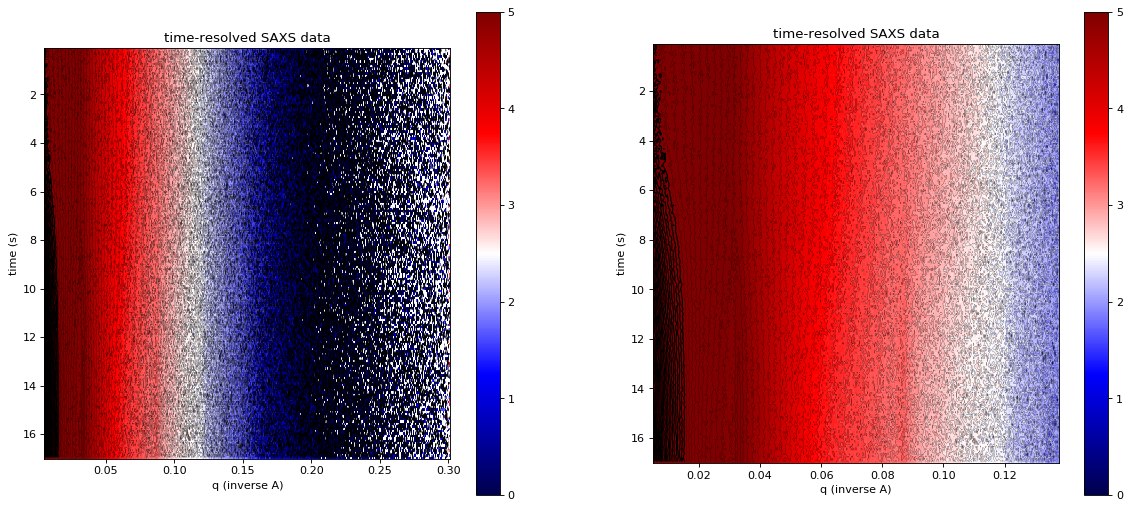

In [65]:
levels1 = np.arange(0,6.5,0.1)
levels2 = np.arange(6,9.5,0.1)
levels3 = np.arange(9.5,15,0.1)
raw_extent=[np.min(raw_q),np.max(raw_q),np.max(raw_t),np.min(raw_t)]
extent=[np.min(q),np.max(q),np.max(t),np.min(t)]
origin='upper'
raw_aspect=max(raw_q)/max(raw_t)
aspect=max(q)/max(t)
plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')
#
plt.subplot(121)
plt.title('time-resolved SAXS data')
plt.xlabel('q (inverse A)')
plt.ylabel('time (s)')
plt.imshow(np.log(raw_data.T), cmap='seismic',vmin=0,vmax=5,origin=origin,extent=raw_extent,aspect=raw_aspect)
plt.colorbar()
plt.contour(np.log(raw_data.T), levels1, linewidths=0.2,colors='k', origin=origin,extent=raw_extent)
plt.contour(np.log(raw_data.T), levels2, linewidths=1,colors='k', origin=origin,extent=raw_extent)
plt.contour(np.log(raw_data.T), levels3, linewidths=0.2,colors='k', origin=origin,extent=raw_extent)
#
plt.subplot(122)
plt.title('time-resolved SAXS data')
plt.xlabel('q (inverse A)')
plt.ylabel('time (s)')
plt.imshow(data.T, cmap='seismic',vmin=0,vmax=5,origin=origin,extent=extent,aspect=aspect)
plt.colorbar()
plt.contour(data.T, levels1, linewidths=0.2,colors='k', origin=origin,extent=extent)
plt.contour(data.T, levels2, linewidths=1,colors='k', origin=origin,extent=extent)
plt.contour(data.T, levels3, linewidths=0.2,colors='k', origin=origin,extent=extent)
#
plt.show()

The data is shown above on a log scale contoured in steps of 1/10, with an emphasis on the area that see Bragg peaks appearing with time.

### Extraction of underlying components

#### 1. PCA
We start by performing the PCA of the data, noting $I$ the sampled intensity function, $C$ its covariance whose eigenvectors $U_{k}(q)$ are associated with the eigenvalues $\sigma^{2}_{k}$ stored in matrix $D$. The singular value decomposition of $I$ explicitely gives its expansion on the basis of the principal components:
$$C(q,q') \propto \sum_{t}I(q,t)I(q',t) = UDU^{T}$$
$$I(q,t) = \sum_{k}\sigma_{k}v_{k}(t)U_{k}(q) = U\Sigma V^{T}$$

In [66]:
# Compute PCA
pca = PCA(n_components=20)
H = pca.fit_transform(data.T)  # Reconstruct signals based on orthogonal components

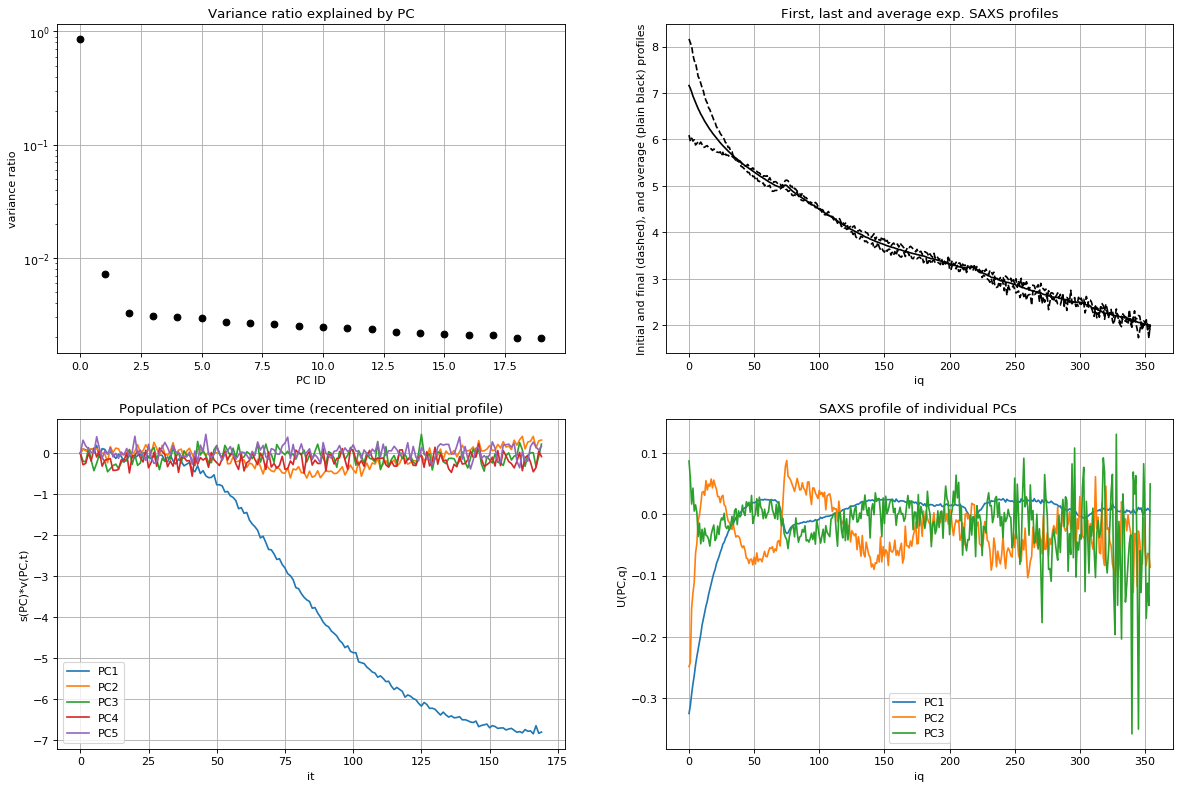

In [67]:
# parameters for figure below
nPCs = 5
eigenval = pca.singular_values_[0:nPCs]
eigenvec = pca.components_.T[:,0:nPCs]
weights  = pca.transform(data.T)
meanvec  = pca.mean_
initvec  = data.T[0,:]
endvec   = data.T[len(t)-1,:]
labels = ['PC1', 'PC2', 'PC3','PC4','PC5']
#
plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')
#
plt.subplot(221)
plt.grid()
plt.title('Variance ratio explained by PC')
plt.xlabel('PC ID')
plt.ylabel('variance ratio')
plt.semilogy(pca.explained_variance_ratio_, 'ko')
#plt.semilogy(np.cumsum(pca.explained_variance_ratio_), 'ko')
#
plt.subplot(222)
plt.grid()
plt.title('First, last and average exp. SAXS profiles')
plt.xlabel('iq')
plt.ylabel('Initial and final (dashed), and average (plain black) profiles')
plt.plot(initvec, 'k--')
plt.plot(endvec, 'k--')
plt.plot(meanvec, color='black')
#
plt.subplot(223)
plt.grid()
plt.title('Population of PCs over time (recentered on initial profile)')
plt.xlabel('it')
plt.ylabel('s(PC)*v(PC,t)')
for i in np.arange(0,nPCs,1):
    wzero = weights[0,i]
    plt.plot(weights[:,i]-wzero, label=labels[i])
plt.legend()
#
plt.subplot(224)
plt.grid()
plt.title('SAXS profile of individual PCs ')
plt.xlabel('iq')
plt.ylabel('U(PC,q)')
for i in np.arange(0,3,1):
    plt.plot(eigenvec[:,i] , label=labels[i])
plt.legend()
#
plt.show()

It appears that the first PC explains most of the data, and that most of the remaining information is explained by the second component. From their population profile, any component after the third one included is mostly noise. We will use this to denoise the data, by projecting it on the two first components, and proceed to find the individual components below.

#### 2. Denoising

This just amounts to keeping the first $L$ (two here) components, so that:
$$C(q,q') \approx C_{L}(q,q') \propto U_{L}D_{L}U_{L}^{T}$$
$$I(q,t) \approx I_{denoised}(q,t) = \sum_{k}^{L}\sigma_{k}v_{k}(t)U_{k}(q) = U_{L}\Sigma_{L} V_{L}^{T}$$

In [70]:
# Compute PCA (only 2 components)
#pca = PCA(n_components=len(t))
pca = PCA(n_components=2)
H = pca.fit_transform(data.T)
V = pca.transform(data.T)
U = pca.components_
denoised = (pca.mean_ + np.dot(U.T,V.T).T).T

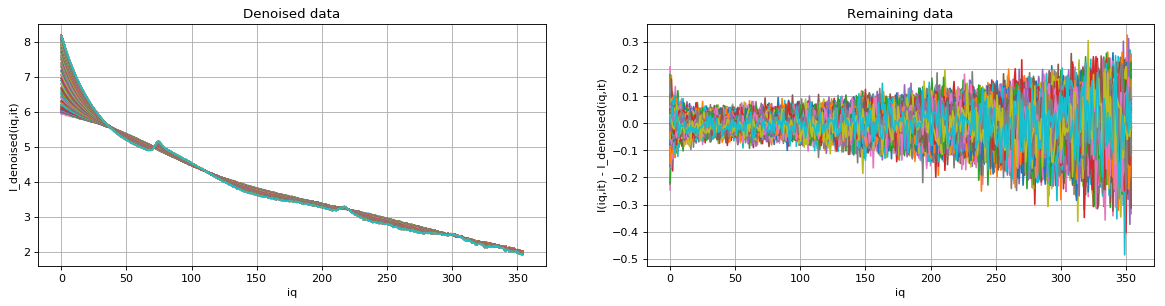

In [71]:
plt.figure(figsize=(18, 4), dpi= 80, facecolor='w', edgecolor='k')
#
plt.subplot(121)
plt.grid()
plt.title('Denoised data')
plt.xlabel('iq')
plt.ylabel('I_denoised(iq,it)')
plt.plot(denoised)
#
plt.subplot(122)
plt.grid()
plt.title('Remaining data')
plt.xlabel('iq')
plt.ylabel('I(iq,it) - I_denoised(iq,it)')
plt.plot(data-denoised)
#
plt.show()

#### 3. fastICA

Here we look for independent components $S(q)$ in the data, by considering the following mixture
$$I_{denoised}(q,t) = \sum_{k}A_{k}(t)S_{k}(q)$$

In [72]:
# Compute ICA
denoised = data
nICs = 2
ica = FastICA(n_components=nICs,algorithm='parallel',fun="logcosh")
S_ = ica.fit_transform(denoised)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

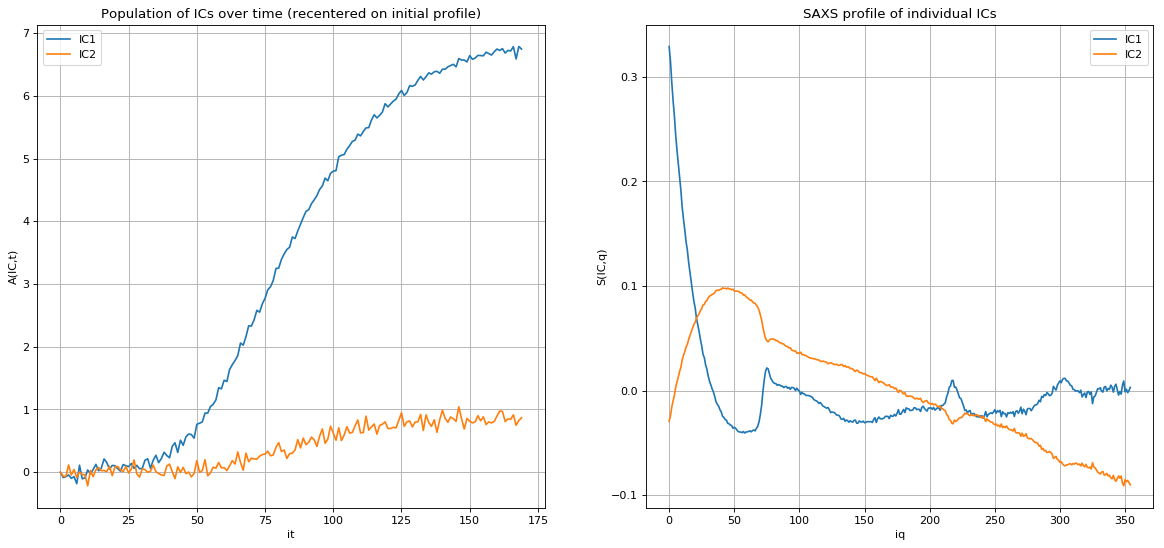

In [73]:
# parameters for figure below
#
labels = ['IC1', 'IC2', 'IC3','IC4', 'IC5', 'IC6','IC7', 'IC8', 'IC9', 'IC10']
#
plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')
#
plt.subplot(121)
plt.grid()
plt.title('Population of ICs over time (recentered on initial profile)')
plt.xlabel('it')
plt.ylabel('A(IC,t)')
for y_arr, label in zip(A_.T, labels):
    yzero = y_arr[0]
    plt.plot(y_arr - yzero, label=label)
plt.legend()
#
plt.subplot(122)
plt.grid()
plt.title('SAXS profile of individual ICs')
plt.xlabel('iq')
plt.ylabel('S(IC,q)')
for y_arr, label in zip(S_.T, labels):
    plt.plot(y_arr , label=label)
plt.legend()
#
plt.show()

### looking again
below we focus on the low-Q region that was left aside above:

In [17]:
qlen = len(raw_q)
qmin = 0 #int(qlen*(1/10)) # int(qlen*(1/100))# int(qlen*(5/100)) # 0
qmax = int(qlen*(12/100))# int(qlen*(0.45)) # int(qlen*(1/2)) # int(qlen*(3/4)) # int(qlen*(1/2))
tlen = len(raw_t)
tmin = 0 # int(tlen*(0.33))
tmax = int(tlen*(1)) # int(tlen*(1))
q = raw_q[qmin:qmax]
t = raw_t[tmin:tmax]
data = np.log(raw_data[qmin:qmax,tmin:tmax])
print("New data size (q,t,I(q,t)) = ",q.shape,t.shape,data.shape)
#
# Compute PCA
pca = PCA(n_components=20)
H = pca.fit_transform(data.T)  # Reconstruct signals based on orthogonal components

## parameters for figure below
nPCs = 5
eigenval = pca.singular_values_[0:nPCs]
eigenvec = pca.components_.T[:,0:nPCs]
weights  = pca.transform(data.T)
meanvec  = pca.mean_
initvec  = data.T[0,:]
endvec   = data.T[len(t)-1,:]
labels = ['PC1', 'PC2', 'PC3','PC4','PC5']
#
plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')
#
plt.subplot(221)
plt.grid()
plt.title('Variance ratio explained by PC')
plt.xlabel('PC ID')
plt.ylabel('variance ratio')
plt.semilogy(pca.explained_variance_ratio_, 'ko')
#plt.semilogy(np.cumsum(pca.explained_variance_ratio_), 'ko')
#
plt.subplot(222)
plt.grid()
plt.title('First, last and average exp. SAXS profiles')
plt.xlabel('iq')
plt.ylabel('Initial and final (dashed), and average (plain black) profiles')
plt.plot(initvec, 'k--')
plt.plot(endvec, 'k--')
plt.plot(meanvec, color='black')
#
plt.subplot(223)
plt.grid()
plt.title('Population of PCs over time (recentered on initial profile)')
plt.xlabel('it')
plt.ylabel('s(PC)*v(PC,t)')
for i in np.arange(0,nPCs,1):
    wzero = weights[0,i]
    plt.plot(weights[:,i]-wzero, label=labels[i])
plt.legend()
#
plt.subplot(224)
plt.grid()
plt.title('SAXS profile of individual PCs ')
plt.xlabel('iq')
plt.ylabel('U(PC,q)')
for i in np.arange(0,2,1):
    plt.plot(eigenvec[:,i] , label=labels[i])
plt.legend()
#
plt.show()
#
denoised = data
nICs = 2
ica = FastICA(n_components=nICs,algorithm='parallel',fun="logcosh")
S_ = ica.fit_transform(denoised)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix
#
# parameters for figure below
#
labels = ['IC1', 'IC2', 'IC3','IC4', 'IC5', 'IC6','IC7', 'IC8', 'IC9', 'IC10']
#
plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')
#
plt.subplot(121)
plt.grid()
plt.title('Population of ICs over time (recentered on initial profile)')
plt.xlabel('it')
plt.ylabel('A(IC,t)')
for y_arr, label in zip(A_.T, labels):
    yzero = y_arr[0]
    plt.plot(y_arr - yzero, label=label)
plt.legend()
#
plt.subplot(122)
plt.grid()
plt.title('SAXS profile of individual ICs')
plt.xlabel('iq')
plt.ylabel('S(IC,q)')
for y_arr, label in zip(S_.T, labels):
    plt.plot(y_arr , label=label)
plt.legend()
#
plt.show()

New data size (q,t,I(q,t)) =  (94,) (250,) (94, 250)


/Users/fpoitevi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### time-structured Independent Component Analysis (tICA)

In [74]:
# Data loading
filename='../data/6_q.csv'
raw_q = genfromtxt(filename,delimiter=',')
filename='../data/6_t.csv'
raw_t = genfromtxt(filename,delimiter=',')
filename='../data/6_array.csv'
raw_data = genfromtxt(filename, delimiter=',')
print("Raw data size (q,t,I(q,t)) = ",raw_q.shape,raw_t.shape,raw_data.shape)
# we prepare the variables if we need to alter the raw variables
# and we alter it a qmax tmax
qlen = len(raw_q)
qmin = 0 # int(qlen*(1/10)) # int(qlen*(1/100))# int(qlen*(5/100)) # 0
qmax = int(qlen*(0.45)) # int(qlen*(1/2)) # int(qlen*(3/4)) # int(qlen*(1/2))
tlen = len(raw_t)
tmin = 0 # int(tlen*(0.05)) # int(tlen*(0.1)) # int(tlen*(0.33))
tmax = int(tlen*(1)) # int(tlen*(1))
q = raw_q[qmin:qmax]
t = raw_t[tmin:tmax]
data = np.log(raw_data[qmin:qmax,tmin:tmax])
print("New data size (q,t,I(q,t)) = ",q.shape,t.shape,data.shape)

Raw data size (q,t,I(q,t)) =  (791,) (170,) (791, 170)
New data size (q,t,I(q,t)) =  (355,) (170,) (355, 170)


In [80]:
# Compute PCA (only 2 components)
#pca = PCA(n_components=len(t))
pca = PCA(n_components=2)
H = pca.fit_transform(data.T)
V = pca.transform(data.T)
U = pca.components_
denoised = (pca.mean_ + np.dot(U.T,V.T).T).T

IndexError: index 2 is out of bounds for axis 1 with size 2

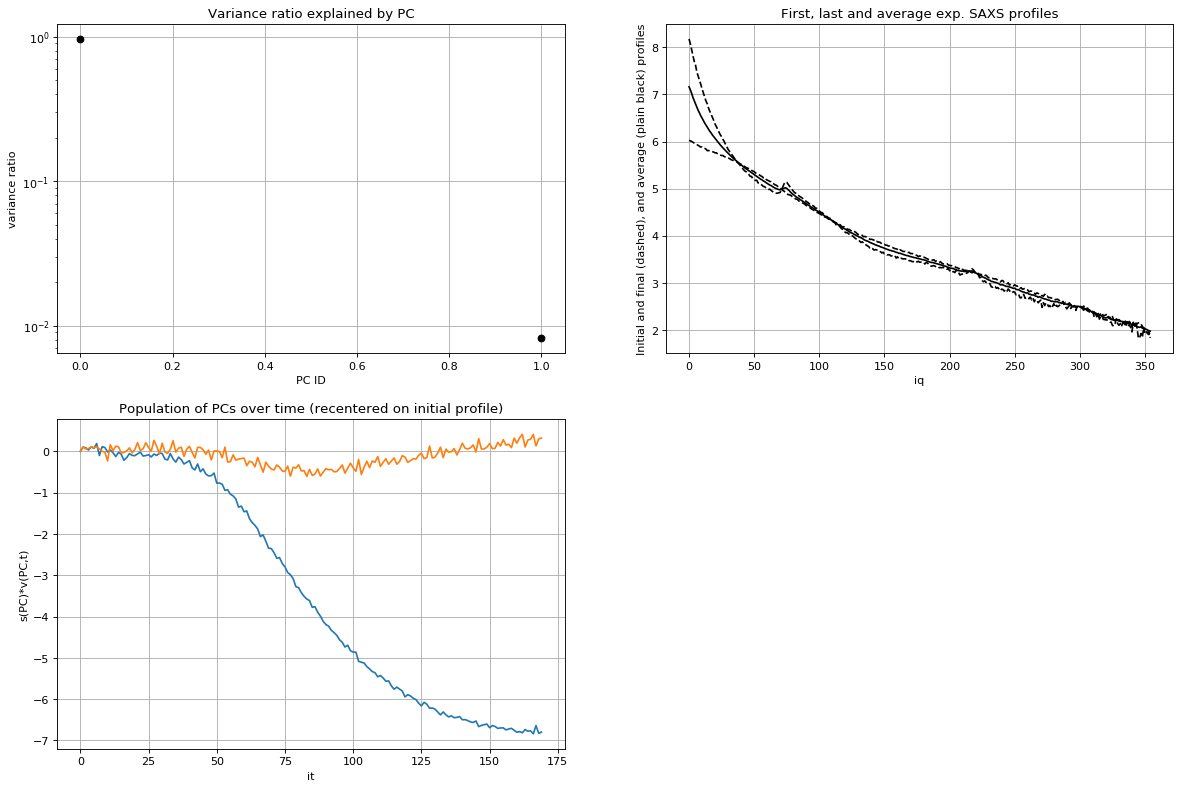

In [81]:
# parameters for figure below
nPCs = 3
eigenval = pca.singular_values_[0:nPCs]
eigenvec = pca.components_.T[:,0:nPCs]
weights  = pca.transform(data.T)
meanvec  = pca.mean_
initvec  = data.T[0,:]
endvec   = data.T[len(t)-1,:]
labels = ['PC1', 'PC2', 'PC3','PC4','PC5']
#
plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')
#
plt.subplot(221)
plt.grid()
plt.title('Variance ratio explained by PC')
plt.xlabel('PC ID')
plt.ylabel('variance ratio')
plt.semilogy(pca.explained_variance_ratio_, 'ko')
#plt.semilogy(np.cumsum(pca.explained_variance_ratio_), 'ko')
#
plt.subplot(222)
plt.grid()
plt.title('First, last and average exp. SAXS profiles')
plt.xlabel('iq')
plt.ylabel('Initial and final (dashed), and average (plain black) profiles')
plt.plot(initvec, 'k--')
plt.plot(endvec, 'k--')
plt.plot(meanvec, color='black')
#
plt.subplot(223)
plt.grid()
plt.title('Population of PCs over time (recentered on initial profile)')
plt.xlabel('it')
plt.ylabel('s(PC)*v(PC,t)')
for i in np.arange(0,nPCs,1):
    wzero = weights[0,i]
    plt.plot(weights[:,i]-wzero, label=labels[i])
plt.legend()
#
plt.subplot(224)
plt.grid()
plt.title('SAXS profile of individual PCs ')
plt.xlabel('iq')
plt.ylabel('U(PC,q)')
for i in np.arange(0,nPCs,1):
    plt.plot(eigenvec[:,i] , label=labels[i])
plt.legend()
#
plt.show()

In [ ]:
#http://msmbuilder.org/development/examples/tICA-vs-PCA.html
#plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
data = denoised
#gmrqlist=[]
#for lag in np.arange(1,99,1):
#    tica = tICA(n_components=2, lag_time=lag)
#    tica.fit([data.T])
#    GMRQ=sum(tica.eigenvalues_)
#    gmrqlist.append(GMRQ)
#plt.grid()
#plt.plot(gmrqlist,'k.')
#plt.show()
#print(max(gmrqlist))
    

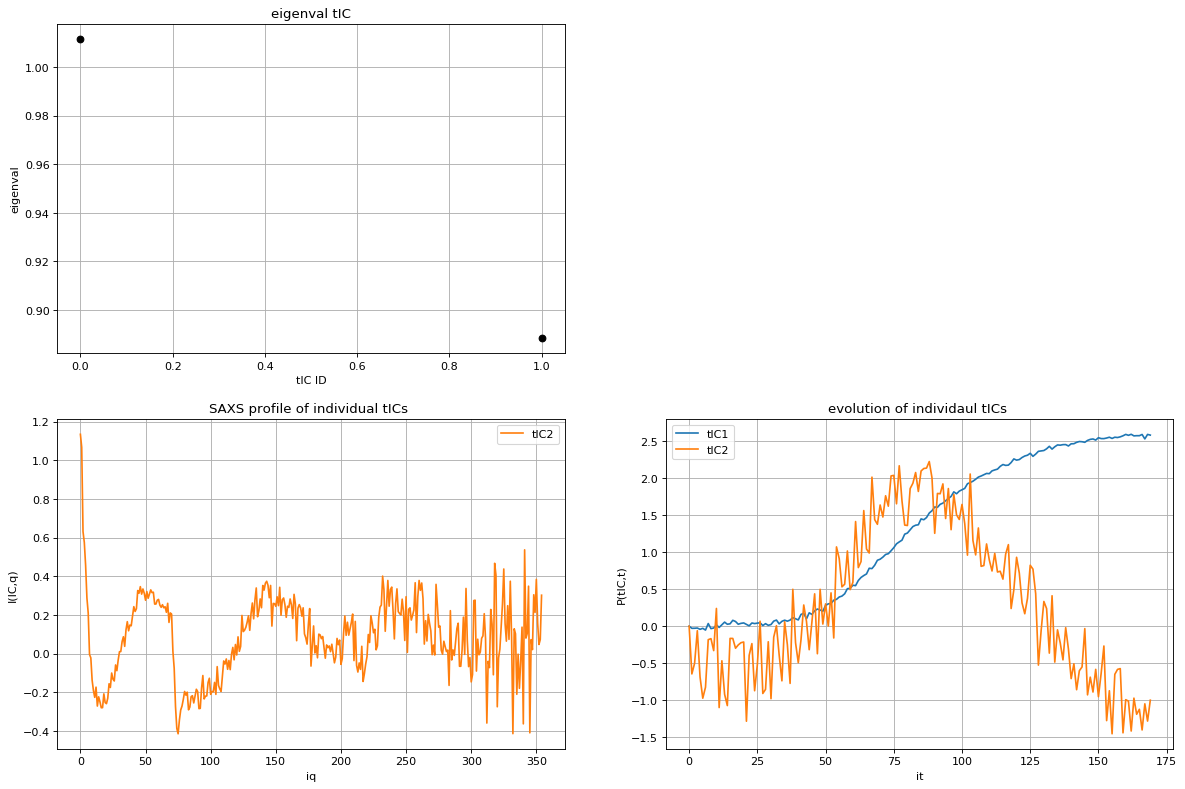

In [87]:
tica = tICA(n_components=2, lag_time=1)
tica.fit([data.T])
ntICs = 2
eigenval = tica.eigenvalues_
eigenvec = tica.components_.T[:,0:ntICs]
weights  = tica.transform([data.T])[0]
labels = ['tIC1', 'tIC2','tIC3', 'tIC4','tIC5', 'tIC6']
#
plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')
#
plt.subplot(221)
plt.grid()
plt.title('eigenval tIC')
plt.xlabel('tIC ID')
plt.ylabel('eigenval')
plt.plot(eigenval, 'ko')
#plt.plot(np.cumsum(eigenval))
#
plt.subplot(223)
plt.grid()
plt.title('SAXS profile of individual tICs ')
plt.xlabel('iq')
plt.ylabel('I(IC,q)')
#plt.plot(0)
for i in np.arange(0,ntICs,1):
    plt.plot(eigenvec[:,i] , label=labels[i])
plt.legend()
#
plt.subplot(224)
plt.grid()
plt.title('evolution of individaul tICs ')
plt.xlabel('it')
plt.ylabel('P(tIC,t)')
for i in np.arange(0,ntICs,1):
    wzero = weights[0,i]
    plt.plot(weights[:,i]-wzero , label=labels[i])
plt.legend()
#
plt.show()
#


Time-scale =  0.0072926832906  s


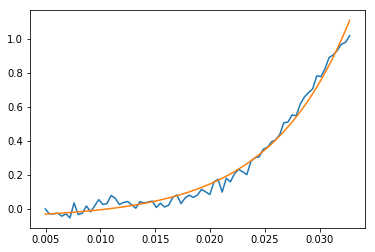

In [96]:
### FIT 
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * np.exp(-b * x) + c
#
xdata = q[0:75]
curve = weights[0:75,0]-weights[0,0]
#
popt, pcov = curve_fit(func, xdata, curve)
y = func(xdata,popt[0],popt[1],popt[2])
plt.plot(xdata,curve)
plt.plot(xdata,y)
#print(popt[0],-1./popt[1],popt[2])
print("Time-scale = ",-1./popt[1]," s")

### Evolving Factor Analysis
Quote from Meisburger et al
*"Although EFA has been used successfully in chromatography for several decades, its application
to chromatography-coupled SAXS has not been described. Methods and associated software for analyzing
SEC-SAXS data using EFA were developed (Fig. S12). First, the buffer-subtracted SAXS profiles collected
during elution were uncertainty-weighted and stored as sequential columns in a matrix, A. Then,
the range of each potentially overlapping peak in the data was determined using EFA.43 Because sudden
jumps in the rank of A occur when new species elute, the start of each component’s peak was identified
by plotting the singular values of the first n columns of A while n was varied (Fig. S13-S14, solid lines in
top panels). Similarly, sudden decreases in the rank of A that signify the end of a peak were found from
the evolution of the singular values of A with the first n columns removed (Fig. S13-S14, dotted lines in
top panels). The values of n where jumps in the rank of A occur were found graphically, and pairs of these
points from the forward and reverse EFA plots defined the peak windows according to the first-in, firstout
principle. Once the peak windows were determined, the basis vectors were rotated to zero the contribution
of each component outside its peak window. Finally, the SAXS profiles for each component and
their estimated uncertainties were calculated (Fig. S13-S14)."*

The idea is to perform SVD on a sliding window, coming up soon...

## Notes
[Extraction of Process-Structure Evolution Linkages from X-ray Scattering Measurements Using Dimensionality Reduction and Time Series Analysis](https://link.springer.com/article/10.1007/s40192-017-0093-4)

[Domain movements upon activation of phenylalanine hydroxylase characterized by crystallography and chromatography-coupled small-angle X-ray scattering](https://pubs.acs.org/doi/pdfplus/10.1021/jacs.6b01563)

